# Molecular dynamics simulations of bulk water

In this example, we show how to perform molecular dynamics of bulk water using the popular interatomic TIP3P potential
([W. L. Jorgensen et. al.](https://doi.org/10.1063/1.445869)) and [LAMMPS](http://lammps.sandia.gov/).

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pylab as plt
from pyiron.project import Project
import ase.units as units
import pandas

In [2]:
pr = Project("tip3p_water")

## Creating the initial structure

We will setup a cubic simulation box consisting of 27 water molecules density density is 1 g/cm$^3$. The target density is achieved by determining the required size of the simulation cell and repeating it in all three spatial dimensions

In [3]:
density = 1.0e-24  # g/A^3
n_mols = 27
mol_mass_water = 18.015 # g/mol

# Determining the supercell size size
mass = mol_mass_water * n_mols / units.mol  # g
vol_h2o = mass / density # in A^3
a = vol_h2o ** (1./3.) # A

# Constructing the unitcell
n = int(round(n_mols ** (1. / 3.)))

dx = 0.7
r_O = [0, 0, 0]
r_H1 = [dx, dx, 0]
r_H2 = [-dx, dx, 0]
unit_cell = (a / n) * np.eye(3)
water = pr.create_atoms(elements=['H', 'H', 'O'], 
                        positions=[r_H1, r_H2, r_O], 
                        cell=unit_cell, pbc=True)
water.set_repeat([n, n, n])
water.plot3d()

NGLWidget()

In [4]:
water.get_chemical_formula()

'H54O27'

## Equilibrate water structure

The initial water structure is obviously a poor starting point and requires equilibration (Due to the highly artificial structure a MD simulation with a standard time step of 1fs shows poor convergence). Molecular dynamics using a time step that is two orders of magnitude smaller allows us to generate an equilibrated water structure. We use the NVT ensemble for this calculation:

In [5]:
water_potential = pandas.DataFrame({    
    'Name': ['H2O_tip3p'],
    'Filename': [[]],
    'Model': ["TIP3P"],
    'Species': [['H', 'O']],
    'Config': [['# @potential_species H_O ### species in potential\n', '# W.L. Jorgensen et.al., The Journal of Chemical Physics 79, 926 (1983); https://doi.org/10.1063/1.445869\n', '#\n', '\n', 'units real\n', 'dimension 3\n', 'atom_style full\n', '\n', '# create groups ###\n', 'group O type 2\n', 'group H type 1\n', '\n', '## set charges - beside manually ###\n', 'set group O charge -0.830\n', 'set group H charge 0.415\n', '\n', '### TIP3P Potential Parameters ###\n', 'pair_style lj/cut/coul/long 10.0\n', 'pair_coeff * * 0.0 0.0 \n', 'pair_coeff 2 2 0.102 3.188 \n', 'bond_style harmonic\n', 'bond_coeff 1 450 0.9572\n', 'angle_style harmonic\n', 'angle_coeff 1 55 104.52\n', 'kspace_style pppm 1.0e-5\n', '\n']]
})

In [6]:
job_name = "water_slow"
ham = pr.create_job("Lammps", job_name)
ham.structure = water
ham.potential = water_potential

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron/lammps/base.py:170: UserWarning: WARNING: Non-'metal' units are not fully supported. Your calculation should run OK, but results may not be saved in pyiron units.
  "WARNING: Non-'metal' units are not fully supported. Your calculation should run OK, but "


In [7]:
ham.calc_md(temperature=300, 
            n_ionic_steps=1e4, 
            time_step=0.01)
ham.run()

The job water_slow was saved and received the ID: 1


In [8]:
view = ham.animate_structure()
view

NGLWidget()

## Full equilibration

At the end of this simulation, we have obtained a structure that approximately resembles water. Now we increase the time step to get a reasonably equilibrated structure 

In [9]:
# Get the final structure from the previous simulation
struct = ham.get_structure(iteration_step=-1)
job_name = "water_fast"
ham_eq = pr.create_job("Lammps", job_name)
ham_eq.structure = struct
ham_eq.potential = water_potential
ham_eq.calc_md(temperature=300, 
               n_ionic_steps=1e4,
               n_print=10, 
               time_step=1)
ham_eq.run()

The job water_fast was saved and received the ID: 2


In [10]:
view = ham_eq.animate_structure()
view

NGLWidget(max_frame=1000)

We can now plot the trajectories

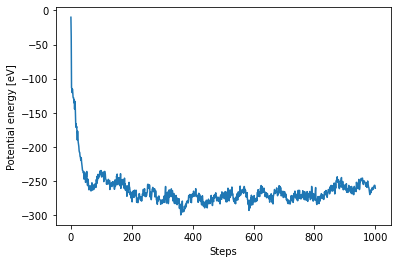

In [11]:
plt.plot(ham_eq["output/generic/energy_pot"])
plt.xlabel("Steps")
plt.ylabel("Potential energy [eV]");

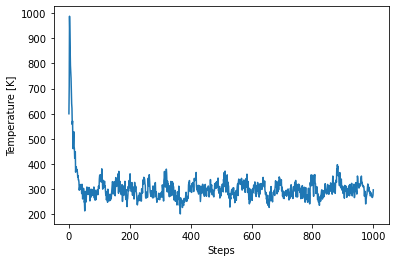

In [12]:
plt.plot(ham_eq["output/generic/temperature"])
plt.xlabel("Steps")
plt.ylabel("Temperature [K]");

## Structure analysis

We will now use the `get_neighbors()` function to determine structural properties from the final structure of the simulation. We take advantage of the fact that the TIP3P water model is a rigid water model which means the nearest neighbors, i.e. the bound H atoms, of each O atom never change. Therefore they need to be indexed only once.

In [13]:
final_struct = ham_eq.get_structure(iteration_step=-1)

# Get the indices based on species
O_indices = final_struct.select_index("O")
H_indices = final_struct.select_index("H")

# Getting only the first two neighbors
neighbors = final_struct.get_neighbors(num_neighbors=2)

### Distribution of the O-H bond length

Every O atom has two H atoms as immediate neighbors. The distribution of this bond length is obtained by:

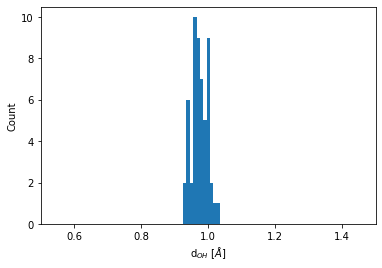

In [14]:
bins = np.linspace(0.5, 1.5, 100)
plt.hist(neighbors.distances[O_indices].flatten(), bins=bins)
plt.xlim(0.5, 1.5)
plt.xlabel(r"d$_{OH}$ [$\AA$]")
plt.ylabel("Count");

### Distribution of the O-O bond lengths

We need to extend the analysis to go beyond nearest neighbors. We do this by using the number of neighbors in a specified cutoff distance

In [15]:
num_neighbors = final_struct.get_numbers_of_neighbors_in_sphere(cutoff_radius=9).max()

In [16]:
neighbors = final_struct.get_neighbors(num_neighbors)

In [17]:
neigh_indices = np.hstack(np.array(neighbors.indices)[O_indices])
neigh_distances = np.hstack(np.array(neighbors.distances)[O_indices])

One is often intended in an element specific pair correlation function. To obtain for example, the O-O coordination function, we do the following:

In [18]:
# Getting the neighboring Oxyhen indices
O_neigh_indices  = np.in1d(neigh_indices, O_indices) 
O_neigh_distances = neigh_distances[O_neigh_indices]

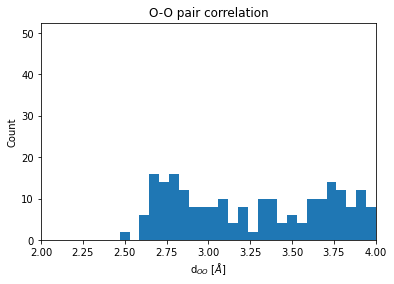

In [19]:
bins = np.linspace(1, 8, 120)
count = plt.hist(O_neigh_distances, bins=bins)
plt.xlim(2, 4)
plt.title("O-O pair correlation")
plt.xlabel(r"d$_{OO}$ [$\AA$]")
plt.ylabel("Count");

We now extent our analysis to include statistically independent snapshots along the trajectory. This allows to obtain the radial pair distribution function of O-O distances in the NVT ensamble.

In [20]:
traj=ham_eq["output/generic/positions"]
nsteps=len(traj)
stepincrement=int(nsteps/10)
# Start sampling snaphots after some equilibration time; do not double count last step.
snapshots=range(stepincrement,nsteps-stepincrement,stepincrement)

In [21]:
for i in snapshots:
    struct.positions = traj[i]
    neighbors = struct.get_neighbors(num_neighbors)
    neigh_indices = np.hstack(np.array(neighbors.indices)[O_indices])
    neigh_distances = np.hstack(np.array(neighbors.distances)[O_indices])
    O_neigh_indices  = np.in1d(neigh_indices, O_indices) 
    #collect all distances in the same array
    O_neigh_distances = np.concatenate((O_neigh_distances,neigh_distances[O_neigh_indices]))

To obtain a radial pair distribution function ($g(r)$), one has to normalize by the volume of the surfce increment of the sphere ($4\pi r^2\Delta r$) and by the number of species, samples, and the number density.

In [22]:
O_gr=np.histogram(O_neigh_distances,bins=bins)
dr=O_gr[1][1]-O_gr[1][0]
normfac=(n/a)**3*n**3*4*np.pi*dr*(len(snapshots)+1)
# (n/a)**3            number density
# n**3                number of species
# (len(snapshots)+1)  number of samples (we also use final_struct)

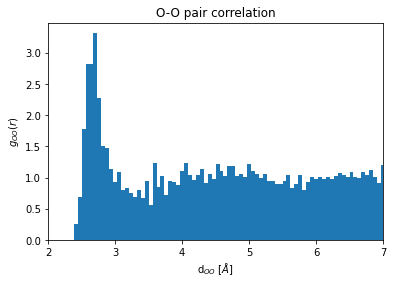

In [23]:
plt.bar(O_gr[1][0:-1],O_gr[0]/(normfac*O_gr[1][0:-1]**2),dr)
plt.xlim(2, 7)
plt.title("O-O pair correlation")
plt.xlabel(r"d$_{OO}$ [$\AA$]")
plt.ylabel("$g_{OO}(r)$");